# Viga del examen

|Quién | Correo | Fecha | Qué hizo |
| ---  | ---    | ---   | ---      |
|Diego Andrés Alvarez Marín | <daalvarez@unal.edu.co> | Marzo 31, 2024  | Código inicial |

Utilizando la **teoría de vigas de Euler-Bernoulli**, calcule los diagramas de fuerza cortante, momento flector, ángulo de giro y deflexión vertical de la viga mostrada en la figura:

<img src="examen.png" width="800">

In [1]:
from sympy import init_printing, latex, DiracDelta, Piecewise, integrate, symbols, Eq, plot, piecewise_fold, solve, Interval, Rational, sets
from sympy.polys.polyfuncs import interpolate
from sympy.abc import x

# Para imprimir bonito
init_printing()
from IPython.display import Math                 
def imprimir (texto1, variable, texto2=""):
    return Math(texto1 +  rf'{latex(variable)}' + texto2)

Se define una función que hace el código más corto y legible, evitando el uso de las [funciones G de Meijerg](https://en.wikipedia.org/wiki/Meijer_G-function):

In [2]:
integre = lambda f, x : integrate(f, x, meijerg=False)

Se define la geometría de la viga y las propiedades del material:



In [3]:
# Posición de los apoyos
x0 = 0                # [m]
x1 = Rational(35, 10) # [m]
x2 = 6                # [m]
xL = Rational(85, 10) # [m]

b = Rational(1, 10)   # [m]   Ancho de la viga
h = Rational(3, 10)   # [m]   Altura de la viga
E = 210_000_000       # [kPa] Módulo de elasticidad de la viga
I = Rational(b*h*h*h, 12)      # [m⁴]  Momento de inercia en z   

# constantes de los resortes
k1 = 1_000 # [kN/m]
k2 = 1_000 # [kN/m]
k3 = 1_000 # [kN/m]
k4 = 1_000 # [kN/m]

Se definen las cargas distribuidas de acuerdo con la tabla 10.3 del `main.pdf`

In [4]:
# Caso 5: carga distribuida variable 
qdist = lambda f,a,b : Piecewise((f, (a < x) & (x < b)), (0, True))

# Funcion rectangular: si x>a y x<b retorne 1 sino retorne 0   
rect = lambda a,b : Piecewise((1, (a < x) & (x < b)), (0, True))

Se especifica la carga distribuida $q(x)$. Observe que aqui no se incluyen los momentos en $x$ = 0 m y $x$ = 6 m ni la carga puntual en $x$ = 8.5 m, ya que  estas se tendra en cuenta cuando se planteen las ecuaciones que resuelven las constantes de integración:

In [5]:
xa = Rational(14, 10) # [m]
xb = 6                # [m]
q  = qdist(interpolate([(xa,2), (xb,-3)], x), xa, xb)   # calcula el polinomio de Lagrange asociado

Se resuelve la ecuación diferencial tramo por tramo:

In [6]:
# Tramo 1: de x=0m a x=4m
C1_1, C1_2, C1_3, C1_4 = symbols('C1_1 C1_2 C1_3 C1_4')
q1 = q*rect(x0,x1)
V1 = integre(q1,x)       + C1_1
M1 = integre(V1,x)       + C1_2
t1 = integre(M1/(E*I),x) + C1_3
v1 = integre(t1,x)       + C1_4

# Tramo 2: de x=4m a x=8m
C2_1, C2_2, C2_3, C2_4 = symbols('C2_1 C2_2 C2_3 C2_4')
q2 = q*rect(x1,x2)
V2 = integre(q2,x)       + C2_1
M2 = integre(V2,x)       + C2_2
t2 = integre(M2/(E*I),x) + C2_3
v2 = integre(t2,x)       + C2_4

# Tramo 3: de x=8m a x=12m
C3_1, C3_2, C3_3, C3_4 = symbols('C3_1 C3_2 C3_3 C3_4')
q3 = q*rect(x2,xL)
V3 = integre(q3,x)       + C3_1
M3 = integre(V3,x)       + C3_2
t3 = integre(M3/(E*I),x) + C3_3
v3 = integre(t3,x)       + C3_4

Se definen las ecuaciones asociadas a cada apoyo:

Apoyo 1:

<img src="apoyo_x0.jpg" width="800">

In [7]:
apoyo_x0 = [
              Eq(v1.subs(x,x0), 0),
              Eq(M1.subs(x,x0) + 3, 0),
           ]

Apoyo 2:

<img src="apoyo_x1.jpg" width="800">

In [8]:
apoyo_x1 = [
              Eq(v1.subs(x,x1), v2.subs(x,x1)),
              Eq(V1.subs(x,x1) + (-k1*v1.subs(x,x1)) - V2.subs(x,x1), 0),
              Eq(M1.subs(x,x1), 0),
              Eq(M2.subs(x,x1), 0),
           ]

Apoyo 3:

<img src="apoyo_x2.jpg" width="800">

In [9]:
apoyo_x2 = [
                  Eq(v2.subs(x,x2), v3.subs(x,x2)),
                  Eq(t2.subs(x,x2), t3.subs(x,x2)),
                  Eq(V2.subs(x,x2) + (-k2*v2.subs(x,x2)) + (-k3*v2.subs(x,x2)) - V3.subs(x,x2), 0),
                  Eq(M3.subs(x,x2) - M2.subs(x,x2) + 8, 0),
           ]

Apoyo 4:

<img src="apoyo_xL.jpg" width="800">

In [10]:
apoyo_xL = [
              Eq(t3.subs(x,xL), 0),
              Eq(V3.subs(x,xL) + 20 + (-k4*v3.subs(x,xL)), 0)
           ]

Se resuelven las ecuaciones para encontrar las constantes de integración::

In [11]:
sol = solve([ 
    *apoyo_x0,
    *apoyo_x1,        
    *apoyo_x2,
    *apoyo_xL,             
],    
[ 
    C1_1, C1_2, C1_3, C1_4,
    C2_1, C2_2, C2_3, C2_4,
    C3_1, C3_2, C3_3, C3_4 
])

Se fusionan las fórmulas y se reemplaza el valor de las constantes de integración:

In [12]:
V = (V1*rect(x0,x1) + V2*rect(x1,x2) + V3*rect(x2,xL)).subs(sol)
M = (M1*rect(x0,x1) + M2*rect(x1,x2) + M3*rect(x2,xL)).subs(sol)
t = (t1*rect(x0,x1) + t2*rect(x1,x2) + t3*rect(x2,xL)).subs(sol)
v = (v1*rect(x0,x1) + v2*rect(x1,x2) + v3*rect(x2,xL)).subs(sol)

Se simplifica lo calculado por sympy:

In [13]:
def simplificar(VMtv, fracciones=True):
    # rewrite(Piecewise) escribe la función como una por partes
    # as_expr_set_pairs() la expresa como una lista de tuplas
    # la tupla tiene dos elementos (función, dominio de validez)
    var = piecewise_fold(VMtv.rewrite(Piecewise)).as_expr_set_pairs(Interval(0, xL))
    tmp = []
    
    # ciclo for sobre cada elemento de la tupla
    for fun, dominio in var:
        # si el dominio es un intervalo o una unión de intervalos
        if isinstance(dominio, sets.sets.Interval | sets.sets.Union):
            if fracciones:
                # intente expresar cualquier número como un fraccionario
                tmp.append((fun.nsimplify(), dominio.as_relational(x)))
            else:
                # intente expresar cualquier fraccionario como un flotante
                tmp.append((fun.evalf(),     dominio.as_relational(x)))
            # as_relational() escribe el dominio como desigualdades y expresiones lógicas

    # exprese la lista de tuplas como una función definida por partes
    return Piecewise(*tmp)

In [14]:
V = simplificar(V)
M = simplificar(M)
t = simplificar(t, fracciones=False)
v = simplificar(v, fracciones=False)

### Se imprimen los resultados

In [15]:
imprimir("V(x) = ", V)

<IPython.core.display.Math object>

In [16]:
imprimir("M(x) = ", M)

<IPython.core.display.Math object>

In [17]:
imprimir(r"\theta(x) = ", t)

<IPython.core.display.Math object>

In [18]:
imprimir("v(x) = ", v)

<IPython.core.display.Math object>

### Se grafican los resultados 

In [19]:
x_xmin_xmax = (x, x0+0.001, xL-0.001)

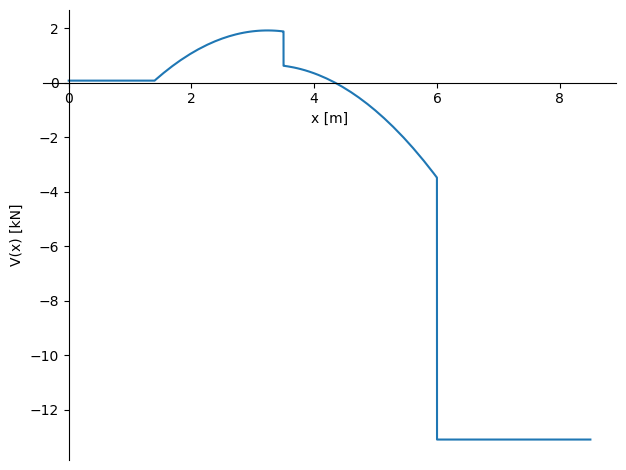

In [20]:
plot(V, x_xmin_xmax, xlabel='x [m]', ylabel='V(x) [kN]')

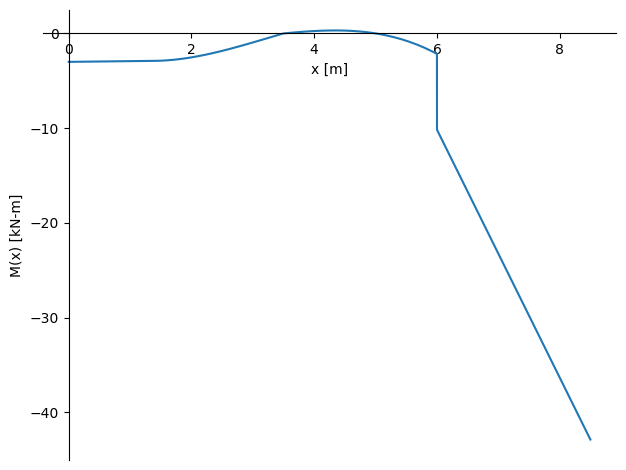

In [21]:
plot(M, x_xmin_xmax, xlabel='x [m]', ylabel='M(x) [kN-m]')

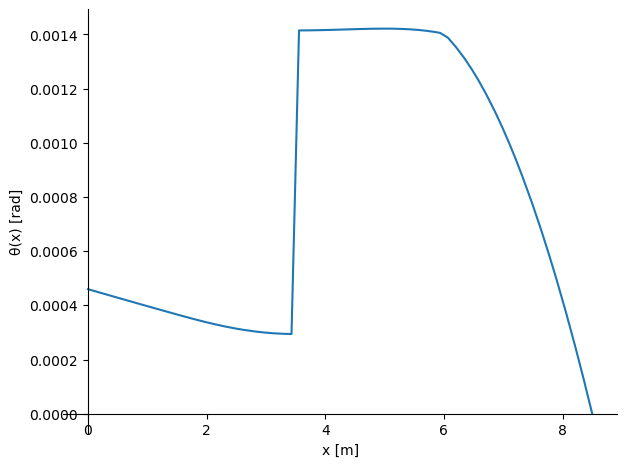

In [22]:
plot(t, x_xmin_xmax, xlabel='x [m]', ylabel='θ(x) [rad]')

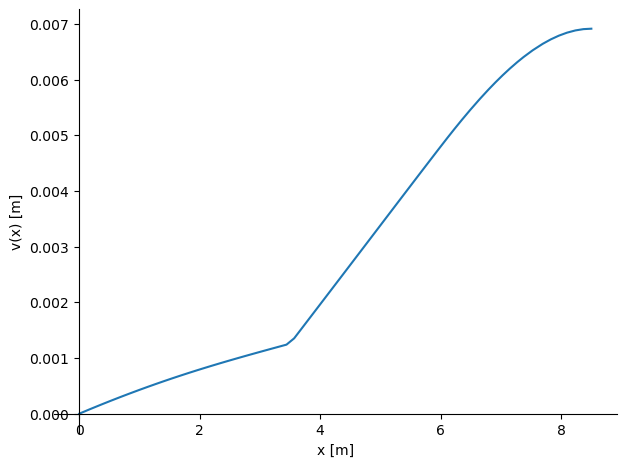

In [23]:
plot(v, x_xmin_xmax, xlabel='x [m]', ylabel='v(x) [m]')

### Se calculan las reacciones en la viga

In [24]:
print(f"Ry(x= 0) = {float(V1.subs(sol).subs(x,x0))} kN")

Ry(x= 0) = 0.07649068322981366 kN


In [25]:
print(f"Resorte 1 (x=3.5) = {float(-k1*v1.subs(sol).subs(x,x1))} kN")

# si se quiere calcular la tracción en el resorte, quite el signo menos

Resorte 1 (x=3.5) = -1.2583321741438427 kN


In [26]:
print(f"Resorte 2 (x=6.0) = {float(-k2*v2.subs(sol).subs(x,x2))} kN")

# si se quiere calcular la compresión en el resorte, se debe dejar el signo menos, ya que el resorte se encuentra arriba

Resorte 2 (x=6.0) = -4.801299312086715 kN


In [27]:
print(f"Resorte 3 (x=6.0) = {float(-k3*v2.subs(sol).subs(x,x2))} kN")

# si se quiere calcular la tracción en el resorte, quite el signo menos

Resorte 3 (x=6.0) = -4.801299312086715 kN


In [28]:
print(f"Resorte 4 (x=8.5) = {float(-k4*v3.subs(sol).subs(x,xL))} kN")

# si se quiere calcular la tracción en el resorte, quite el signo menos

Resorte 4 (x=8.5) = -6.9155598849125415 kN


In [29]:
print(f"Rm(x=8.5) = {float(M3.subs(sol).subs(x,xL))} kN m")

Rm(x=8.5) = -42.8713199570327 kN m
